In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from matplotlib.backends.backend_pdf import PdfPages
import pickle
from scipy import spatial
import os
from os.path import dirname, abspath
import warnings
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from itertools import combinations

In [2]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensional dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the standard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the standard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

def plt_scatter(spec, labels, batches, fontsize=15):
    def plt_scatter_group(spec, batches, label, ax):
        uni_batch = np.unique(batches)
        m_pca = PCA(n_components = 3).fit_transform(spec)
        cols = ('gray', 'blue', 'm')
        for b in range(3):
            ix = np.argwhere(batches==uni_batch[b])[:, 0]
            ax.scatter(m_pca[ix, 0], m_pca[ix, 1], color=cols[b], label=uni_batch[b])
            confidence_ellipse(m_pca[ix, 0], m_pca[ix, 1], ax, alpha=0.25, facecolor=cols[b], edgecolor='grey', zorder=0) 

        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_title(label)
        ax.legend(loc='upper left', fontsize=fontsize)
        
    uni_label = np.unique(labels)
    fig, ax = plt.subplots(1, len(uni_label),  figsize=(15, 5))
    for l in range(len(uni_label)):
        ix = np.argwhere(labels==uni_label[l])[:,0]
        plt_scatter_group(spec[ix, :], batches[ix], uni_label[l], ax[l])
    plt.tight_layout()
    plt.show()            

def plt_mean(wn, spec, group, gap=0, title='', legend=True, uni_group=None, fontsize=10):
    if uni_group is None:
        uni_group = np.unique(group)
    fig, ax = plt.subplots(1, 1,  figsize=(7, 5))
    for i in range(len(uni_group)):
        ix = np.argwhere(group == uni_group[i])[:, 0]
        ax.plot(wn, np.mean(spec[ix, :], axis=0) + i*gap, label=uni_group[i])
    ax.set_xlabel('Wavenumber / $cm^{-1}$', fontsize=fontsize)
    ax.set_ylabel('Raman Intensity / arb.u.', fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    if legend:
        ax.legend(loc='best', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.tight_layout()
    plt.show()

In [3]:
metadata = pd.read_csv(dirname(abspath(os.getcwd())) + '/datasets/bacterial_SSP/metadata.csv')
spec = pd.read_csv(dirname(abspath(os.getcwd())) + '/datasets/bacterial_SSP/data.csv')
wn = np.array(spec.iloc[0,1:])
spec = np.array(spec.iloc[1:,1:])
labels = np.array(metadata['labels'])
batches = np.array(metadata['batches'])

ix_wn = np.asarray(range(len(wn)))[(wn>1850) & (wn<2750)]
ix_wn1 = np.asarray(range(len(wn)))[(wn<1800) | (wn>2800)]

for i in range(spec.shape[0]):
    spec[i,:] = spec[i, :]/np.sqrt(np.sum(spec[i, :]**2))

ix = np.argwhere((labels != 'L-innocua') & (labels != 'P-stutzeri'))[:,0]
spec = spec[ix, :]
labels = labels[ix]
batches = batches[ix]

corr_all = np.mean(np.corrcoef(spec), 0)
i_good = corr_all>np.percentile(corr_all, 1)
spec = spec[i_good, :]
labels = labels[i_good]
batches = batches[i_good]

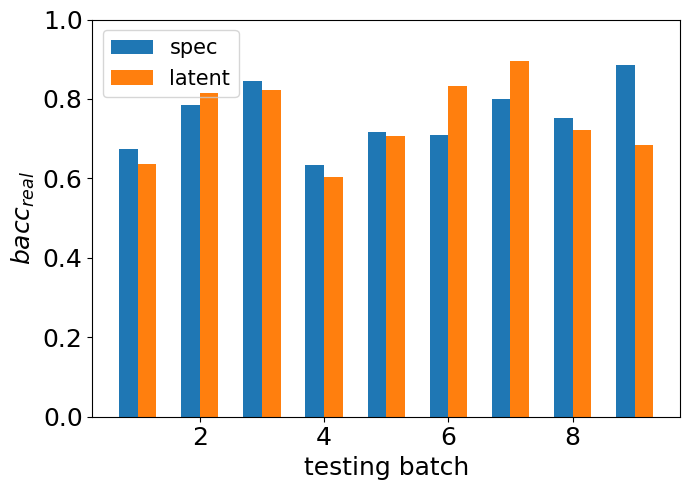

In [4]:
with open(dirname(abspath(os.getcwd())) + '/results/accs_8_batch.pkl', 'rb') as f:
    accs1, min_accs1, b_trains, b_tests, methods = pickle.load(f)

cols = list(mcolors.TABLEAU_COLORS)
fig, ax = plt.subplots(1, 1,  figsize=(7, 5))
uni_method = ['0-spec', '1-latent'] #, '2-aug1', '3-aug2', '4-aug1', '5-aug2', '6-gen1']
for i_b in range(len(np.unique(b_tests))):
    ix = np.argwhere(b_tests==np.unique(b_tests)[i_b])
    accs_all = []
    min_accs_all = []
    std_accs_all = []
    for i_m in range(len(uni_method)):
        ixx = np.argwhere(methods[ix]==uni_method[i_m])[:,0]
        vals = accs1[ix][ixx]
        min_vals = min_accs1[ix][ixx]
        ax.bar(1+i_b+(-1)**(i_m-1)*0.15, np.nanmean(vals), width=0.3, color=cols[i_m])
        # ax[1].bar(i_b+(i_m-1)*0.3, np.nanmean(min_vals), width=0.3, color=cols[i_m])
        # if i_b==3:
        #     print([vals, min_vals])
    ax.set_xlabel('testing batch', fontsize=18)
    ax.set_ylabel('$bacc_{real}$', fontsize=18)
    ax.set_ylim((0, 1))
    # ax[1].set_xlabel('testing batch')
    # ax[1].set_ylabel('minimal sensitivity')
    leg = ax.legend(['spec', 'latent'], loc='upper left', fontsize=15)
    leg.get_frame().set_facecolor('none')
    # leg.get_frame().set_linewidth(0.0)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
plt.tight_layout()
plt.show()
plt.close()

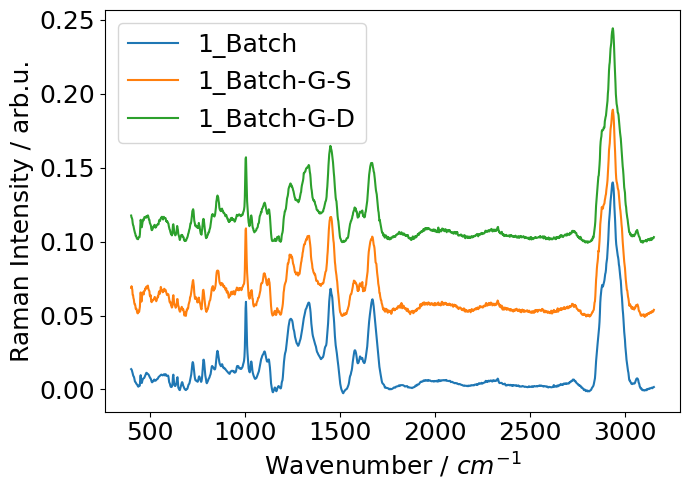

In [5]:
n_spec_gen = 60
with open(dirname(abspath(os.getcwd())) + '/datasets/data_gen_0.pkl', 'rb') as f:
    y_gen, c_gen, c_rea, g_gen, b_gen = pickle.load(f)


uni_batches = np.unique(batches)
index = np.array(range(len(uni_batches)))
bat = []
for k in combinations(index, 8):
    bat.append(k)
bat = np.row_stack(bat)
bat = bat[np.array(range(0, bat.shape[0], np.max([1, bat.shape[0]//9]))), :]
k = bat[0,:]

batch_sel = np.array([uni_batches[i] for i in k])
    
ix = [] 
for b in batch_sel:
    if len(ix)<1:
        ix = (batches==b)
    else:
        ix = (ix) | (batches==b)
ix = np.array(np.argwhere(ix==True)[:,0])

spec_gen = []
label_gen = []
batch_gen = []
for i in range(len(ix)):
    spec_gen.append(spec[ix[i], :])
    label_gen = np.append(label_gen, labels[ix[i]])  
    batch_gen = np.append(batch_gen, batches[ix[i]])  
    g_in_out = g_gen[(i*n_spec_gen):(i*n_spec_gen+n_spec_gen)]
    b_in_out = b_gen[(i*n_spec_gen):(i*n_spec_gen+n_spec_gen)]
    ix_pair = np.argwhere((g_in_out>0.5))[:,0]
    ix_pair = np.random.choice(ix_pair, 1, replace=False)
    spec_gen.append(y_gen[i*n_spec_gen+ix_pair, :1376])
    label_gen = np.append(label_gen, labels[ix[i]])  
    for j in [ix_pair]:
        if b_in_out[j]<0.5:
            batch_gen = np.append(batch_gen, batches[ix[i]]+'-G-D')  
        else:
            batch_gen = np.append(batch_gen, batches[ix[i]]+'-G-S')  
spec_gen = np.row_stack(spec_gen)

for i in range(spec_gen.shape[0]):
    spec_gen[i,:] = spec_gen[i, :]/np.sqrt(np.sum(spec_gen[i, :]**2))


ix_plot = np.argwhere((label_gen == 'E-coli'))[:,0]
# plt_mean(wn, spec_gen[ix_plot, :], batch_gen[ix_plot], gap=0.05, title='Mean of real and generated spectra (E-coli)', legend=True, uni_group=['1_Batch', '1_Batch-G-S', '1_Batch-G-D'], fontsize=18)
plt_mean(wn, spec_gen[ix_plot, :], batch_gen[ix_plot], gap=0.05, title='', legend=True, uni_group=['1_Batch', '1_Batch-G-S', '1_Batch-G-D'], fontsize=18)

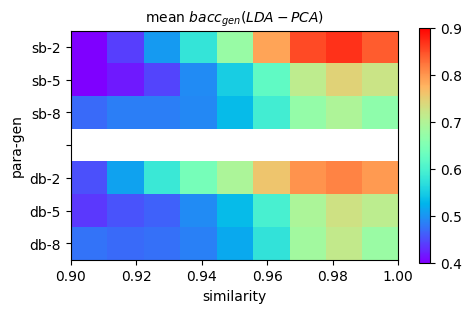

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
cols = list(mcolors.TABLEAU_COLORS)

db_methods = ['']
n_bats = [2, 5, 8]
for i_m in range(len(db_methods)):
    m = db_methods[i_m]
    accs_all = []
    for n_bat in range(len(n_bats)):
        with open(dirname(abspath(os.getcwd())) + '/results/accs_mt1_gen_' + str(n_bats[n_bat]) + '_batch.pkl', 'rb') as f:
            accs, methods, b_trains, val_cors = pickle.load(f)
        
        uni_cors = np.unique(val_cors)[1:]
        c_vals = np.array(range(90, 99))
        ix = np.argwhere(methods=='sb'+m)[:,0]
        tc_tmp = val_cors[ix]
        for tc in uni_cors:
            ixx = np.argwhere(tc_tmp == tc)[:,0]
            vals = accs[ix][ixx]
            accs_all = np.append(accs_all, np.mean(vals))
    accs_all = np.append(accs_all, np.resize(np.nan, len(uni_cors)))
    for n_bat in range(len(n_bats)):
        with open(dirname(abspath(os.getcwd())) + '/results/accs_mt1_gen_' + str(n_bats[n_bat]) + '_batch.pkl', 'rb') as f:
            accs, methods, b_trains, val_cors = pickle.load(f)
        
        uni_cors = np.unique(val_cors)[1:]
        c_vals = np.array(range(90, 99))
        ix = np.argwhere(methods=='db'+m)[:,0]
        tc_tmp = val_cors[ix]
        for tc in uni_cors:
            ixx = np.argwhere(tc_tmp == tc)[:,0]
            vals = accs[ix][ixx]
            accs_all = np.append(accs_all, np.mean(vals))
            
    accs_all = np.reshape(accs_all, [2*len(n_bats)+1, len(uni_cors)])
    if m=='':
        acc_none = accs_all.copy()
    # accs_all = np.row_stack([np.resize(acc_org, len(np.unique(uni_cors))), accs_all])

    pl = ax.imshow(accs_all, 'rainbow', extent=(0.9, 1, 2*len(n_bats)+1, 0), aspect=0.01, vmin=0.4, vmax=0.9)
    fig.colorbar(pl, ax=ax, shrink=0.5)
    ax.set_ylabel('para-gen', fontsize=10)
    ax.set_xlabel('similarity', fontsize=10)
    ax.set_title('mean $bacc_{gen}(LDA-PCA)$', fontsize=10)
    if m =='':
        m = '-none'
    # ax.set_title(m[1:], fontsize=10)  
    ax.set_yticks(np.array(range(2*len(n_bats)+1))+0.5, ('sb-2', 'sb-5', 'sb-8', '', 'db-2','db-5', 'db-8'), fontsize=10) 
    
plt.tight_layout()
plt.show()

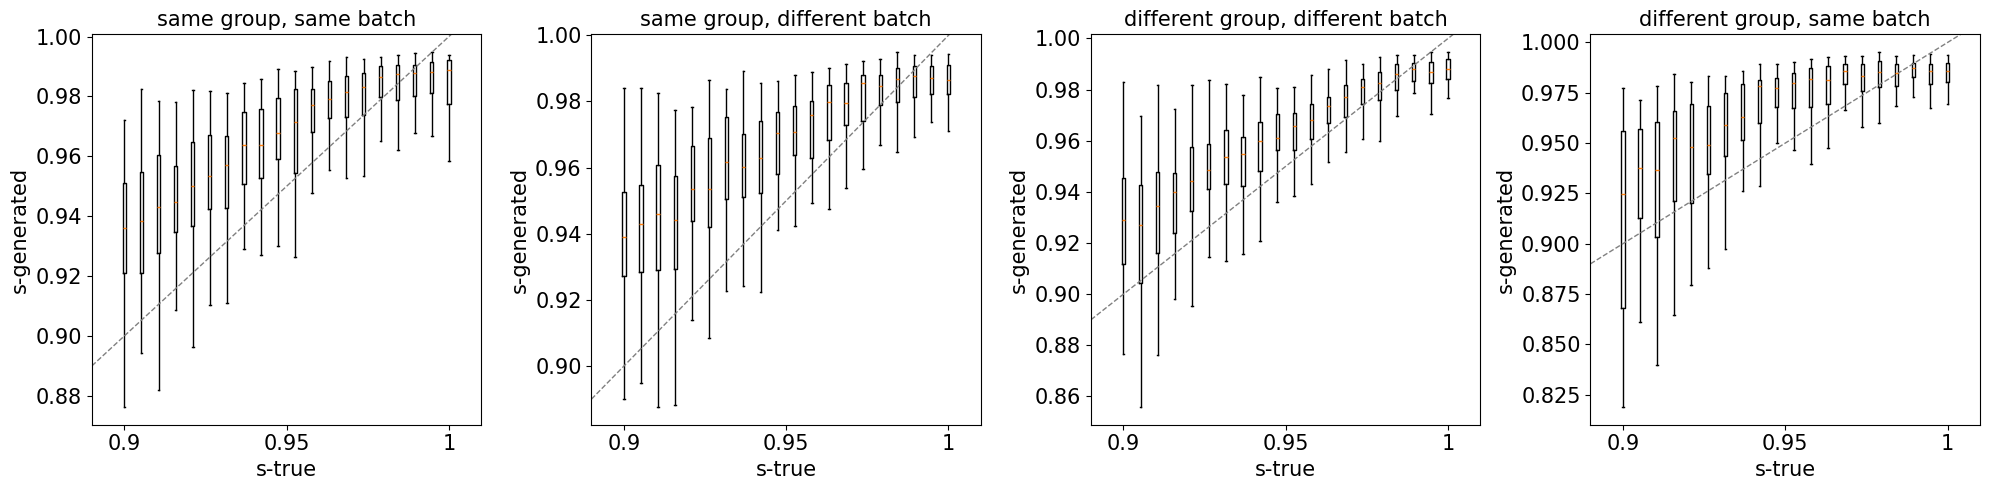

In [7]:
with open(dirname(abspath(os.getcwd())) + '/datasets/data_gen_all_0.pkl', 'rb') as f:
    y_gen, c_gen, c_rea, g_gen, b_gen = pickle.load(f)
    
ix_sb_sg = (b_gen>0.5) & (g_gen>0.5)
ix_db_sg = (b_gen<0.5) & (g_gen>0.5)
ix_sb_dg = (b_gen>0.5) & (g_gen<0.5)
ix_db_dg = (b_gen<0.5) & (g_gen<0.5)

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
c_gen_sb_sg = c_gen[ix_sb_sg]
c_gen_db_sg = c_gen[ix_db_sg]
c_gen_db_dg = c_gen[ix_db_dg]
c_gen_sb_dg = c_gen[ix_sb_dg]

c_rea_sb_sg = c_rea[ix_sb_sg]
c_rea_db_sg = c_rea[ix_db_sg]
c_rea_db_dg = c_rea[ix_db_dg]
c_rea_sb_dg = c_rea[ix_sb_dg]

for c in np.asarray(np.linspace(90, 100, 20)/100.0):
    ix_plt = c_rea_sb_sg==c
    ax[0].boxplot(c_gen_sb_sg[ix_plt], positions=[c], widths=0.001, showfliers=False)
    ix_plt = c_rea_db_sg==c
    ax[1].boxplot(c_gen_db_sg[ix_plt], positions=[c], widths=0.001, showfliers=False)
    ix_plt = c_rea_db_dg==c
    ax[2].boxplot(c_gen_db_dg[ix_plt], positions=[c], widths=0.001, showfliers=False)
    ix_plt = c_rea_sb_dg==c
    ax[3].boxplot(c_gen_sb_dg[ix_plt], positions=[c], widths=0.001, showfliers=False)

ax[0].axline((np.min(c_rea_sb_sg), np.min(c_rea_sb_sg)), slope=1, linewidth=1, color='gray', linestyle='--')
ax[0].set_xlabel('s-true', fontsize=15)
ax[0].set_ylabel('s-generated', fontsize=15)
ax[0].set_title('same group, same batch', fontsize=15)
ax[0].set_xlim((0.89, 1.01))
ax[0].set_xticks([0.9, 0.95, 1], [0.9, 0.95, 1], fontsize=15) 
ax[0].tick_params('both', labelsize=15)
# ax[0, 1].scatter(c_rea_db_sg*100, c_gen_db_sg*100)
ax[1].axline((np.min(c_rea_db_sg), np.min(c_rea_db_sg)), slope=1, linewidth=1, color='gray', linestyle='--')
ax[1].set_xlabel('s-true', fontsize=15)
ax[1].set_ylabel('s-generated', fontsize=15)
ax[1].set_title('same group, different batch', fontsize=15)
ax[1].set_xticks([0.9, 0.95, 1], [0.9, 0.95, 1], fontsize=15) 
ax[1].set_xlim((0.89, 1.01))
ax[1].tick_params('both', labelsize=15)
# ax[1, 0].scatter(c_rea_db_dg*100, c_gen_db_dg*100)
ax[2].axline((np.min(c_rea_db_dg), np.min(c_rea_db_dg)), slope=1, linewidth=1, color='gray', linestyle='--')
ax[2].set_xlabel('s-true', fontsize=15)
ax[2].set_ylabel('s-generated', fontsize=15)
ax[2].set_title('different group, different batch', fontsize=15)
ax[2].set_xticks([0.9, 0.95, 1], [0.9, 0.95, 1], fontsize=15) 
ax[2].set_xlim((0.89, 1.01))
ax[2].tick_params('both', labelsize=15)
# ax[1, 1].scatter(c_rea_sb_dg*100, c_gen_sb_dg*100)
ax[3].axline((np.min(c_rea_sb_dg), np.min(c_rea_sb_dg)), slope=1, linewidth=1, color='gray', linestyle='--')
ax[3].set_xlabel('s-true', fontsize=15)
ax[3].set_ylabel('s-generated', fontsize=15)
ax[3].set_title('different group, same batch', fontsize=15)
ax[3].set_xticks([0.9, 0.95, 1], [0.9, 0.95, 1], fontsize=15) 
ax[3].set_xlim((0.89, 1.01))
# plt.yticks(fontsize=15)
ax[3].tick_params('both', labelsize=15)
plt.tight_layout()
plt.show()